In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from Custom_RCNN import modify_fasterrcnn

device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT
# Load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights).to(device)
model = modify_fasterrcnn(model, num_classes=2).to(device) # surgery on output classes
transforms=weights.transforms()

# load weights
# model.load_state_dict(torch.load("weights/epoch_2.pth"))

# load category dict
charname_to_id=["bg","char"]
model.category_dict=charname_to_id
# model.category_dict=weights.meta["categories"]

Using device: cuda


In [2]:
# Load dataset
from dataset import CuneiformDataset,collate_fn
from torch.utils.data import DataLoader
dataset = CuneiformDataset("../MaiCuBeDa/train_photo_anno.json", transforms=transforms,label_key="is_char")
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=4,collate_fn=collate_fn)
# Get one batch
images, targets = next(iter(dataloader))

In [3]:
num_epochs = 5
base_lr = 1e-5
weight_decay = 1e-4

model.train()

# Example: freeze all backbone layers except layer4
# for name, param in model.backbone.body.named_parameters():
#     if "layer4" in name and "BatchNorm" not in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False


optimizer = torch.optim.AdamW(
    (p for p in model.parameters() if p.requires_grad),
    lr=base_lr,
    weight_decay=weight_decay,
)


lr_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=1.0, end_factor=1e-3, total_iters=num_epochs
)

trainable_params = len( list(model.parameters()))
print(f"Trainable parameters: {trainable_params}")

print_every = 10  # batches
resume_from=8
model.load_state_dict(torch.load("weights/epoch_{}.pth".format(resume_from-1)))
optimizer.load_state_dict(torch.load("weights/optimizer_epoch_{}.pth".format(resume_from-1)))

Trainable parameters: 83


C:\Users\zyr\AppData\Local\Temp\ipykernel_26948\2682674119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("weights/epoch_{}.pth".forma

In [4]:
from tqdm import tqdm
import torch

model.train()
for epoch in range(resume_from, resume_from+num_epochs):
    # Initialize accumulators for total loss and individual losses
    loss_accumulators = {k: 0.0 for k in ["total"]}  # will dynamically expand
    for batch_idx, (images, targets) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Compute total loss (equal weights)
        total_loss = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate all losses for averaging
        for k, v in loss_dict.items():
            if k not in loss_accumulators:
                loss_accumulators[k] = 0.0
            loss_accumulators[k] += v.item()
        loss_accumulators["total"] += total_loss.item()

        # Print every few batches
        if (batch_idx + 1) % print_every == 0:
            avg_losses = {k: v / print_every for k, v in loss_accumulators.items()}
            loss_str = ", ".join([f"{k}: {v:.4f}" for k, v in avg_losses.items()])
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)} — {loss_str}")

            # reset accumulators
            for k in loss_accumulators:
                loss_accumulators[k] = 0.0

    lr_scheduler.step()
    torch.save(model.state_dict(), f"weights/epoch_{epoch}.pth")
    torch.save(optimizer.state_dict(), f"weights/optimizer_epoch_{epoch}.pth")


Epoch 9/5:   3%|▎         | 10/286 [01:35<59:16, 12.88s/it] 

Epoch 9/5, Batch 10/286 — total: 1.1483, loss_classifier: 0.3703, loss_box_reg: 0.5367, loss_objectness: 0.1407, loss_rpn_box_reg: 0.1006


Epoch 9/5:   7%|▋         | 20/286 [02:56<37:03,  8.36s/it]  

Epoch 9/5, Batch 20/286 — total: 1.1440, loss_classifier: 0.3589, loss_box_reg: 0.5236, loss_objectness: 0.1372, loss_rpn_box_reg: 0.1243


Epoch 9/5:  10%|█         | 30/286 [04:23<28:36,  6.70s/it]

Epoch 9/5, Batch 30/286 — total: 1.2065, loss_classifier: 0.3878, loss_box_reg: 0.5612, loss_objectness: 0.1452, loss_rpn_box_reg: 0.1122


Epoch 9/5:  14%|█▍        | 40/286 [06:17<39:40,  9.68s/it]

Epoch 9/5, Batch 40/286 — total: 1.1315, loss_classifier: 0.3511, loss_box_reg: 0.5472, loss_objectness: 0.1229, loss_rpn_box_reg: 0.1102


Epoch 9/5:  17%|█▋        | 50/286 [07:33<31:58,  8.13s/it]

Epoch 9/5, Batch 50/286 — total: 1.0856, loss_classifier: 0.3325, loss_box_reg: 0.5260, loss_objectness: 0.1246, loss_rpn_box_reg: 0.1025


Epoch 9/5:  21%|██        | 60/286 [09:03<34:34,  9.18s/it]

Epoch 9/5, Batch 60/286 — total: 1.1122, loss_classifier: 0.3400, loss_box_reg: 0.5283, loss_objectness: 0.1521, loss_rpn_box_reg: 0.0917


Epoch 9/5:  24%|██▍       | 70/286 [10:16<39:01, 10.84s/it]

Epoch 9/5, Batch 70/286 — total: 1.0778, loss_classifier: 0.3288, loss_box_reg: 0.5424, loss_objectness: 0.1144, loss_rpn_box_reg: 0.0921


Epoch 9/5:  28%|██▊       | 80/286 [11:27<29:51,  8.70s/it]

Epoch 9/5, Batch 80/286 — total: 1.1486, loss_classifier: 0.3514, loss_box_reg: 0.5166, loss_objectness: 0.1700, loss_rpn_box_reg: 0.1107


Epoch 9/5:  31%|███▏      | 90/286 [12:34<23:41,  7.25s/it]

Epoch 9/5, Batch 90/286 — total: 1.1463, loss_classifier: 0.3658, loss_box_reg: 0.5291, loss_objectness: 0.1420, loss_rpn_box_reg: 0.1094


Epoch 9/5:  35%|███▍      | 100/286 [13:17<15:05,  4.87s/it]

Epoch 9/5, Batch 100/286 — total: 1.1117, loss_classifier: 0.3491, loss_box_reg: 0.5306, loss_objectness: 0.1272, loss_rpn_box_reg: 0.1048


Epoch 9/5:  38%|███▊      | 110/286 [14:41<25:50,  8.81s/it]

Epoch 9/5, Batch 110/286 — total: 1.1139, loss_classifier: 0.3608, loss_box_reg: 0.5320, loss_objectness: 0.1126, loss_rpn_box_reg: 0.1085


Epoch 9/5:  42%|████▏     | 120/286 [15:51<11:14,  4.07s/it]

Epoch 9/5, Batch 120/286 — total: 1.1488, loss_classifier: 0.3471, loss_box_reg: 0.5273, loss_objectness: 0.1616, loss_rpn_box_reg: 0.1128


Epoch 9/5:  45%|████▌     | 130/286 [16:52<11:31,  4.43s/it]

Epoch 9/5, Batch 130/286 — total: 1.2204, loss_classifier: 0.3867, loss_box_reg: 0.5890, loss_objectness: 0.1411, loss_rpn_box_reg: 0.1037


Epoch 9/5:  49%|████▉     | 140/286 [17:53<12:26,  5.11s/it]

Epoch 9/5, Batch 140/286 — total: 1.1008, loss_classifier: 0.3385, loss_box_reg: 0.5351, loss_objectness: 0.1221, loss_rpn_box_reg: 0.1052


Epoch 9/5:  52%|█████▏    | 150/286 [18:57<15:49,  6.98s/it]

Epoch 9/5, Batch 150/286 — total: 1.1290, loss_classifier: 0.3496, loss_box_reg: 0.5257, loss_objectness: 0.1501, loss_rpn_box_reg: 0.1037


Epoch 9/5:  56%|█████▌    | 160/286 [19:51<10:18,  4.91s/it]

Epoch 9/5, Batch 160/286 — total: 1.1280, loss_classifier: 0.3557, loss_box_reg: 0.5152, loss_objectness: 0.1418, loss_rpn_box_reg: 0.1153


Epoch 9/5:  59%|█████▉    | 170/286 [21:11<17:51,  9.24s/it]

Epoch 9/5, Batch 170/286 — total: 1.0981, loss_classifier: 0.3453, loss_box_reg: 0.5179, loss_objectness: 0.1196, loss_rpn_box_reg: 0.1152


Epoch 9/5:  63%|██████▎   | 180/286 [22:06<09:40,  5.48s/it]

Epoch 9/5, Batch 180/286 — total: 1.0383, loss_classifier: 0.3464, loss_box_reg: 0.5035, loss_objectness: 0.1140, loss_rpn_box_reg: 0.0744


Epoch 9/5:  66%|██████▋   | 190/286 [23:08<09:09,  5.72s/it]

Epoch 9/5, Batch 190/286 — total: 1.0935, loss_classifier: 0.3386, loss_box_reg: 0.5362, loss_objectness: 0.1248, loss_rpn_box_reg: 0.0939


Epoch 9/5:  70%|██████▉   | 200/286 [24:32<10:19,  7.20s/it]

Epoch 9/5, Batch 200/286 — total: 1.0568, loss_classifier: 0.3341, loss_box_reg: 0.5121, loss_objectness: 0.1210, loss_rpn_box_reg: 0.0895


Epoch 9/5:  73%|███████▎  | 210/286 [25:44<12:03,  9.52s/it]

Epoch 9/5, Batch 210/286 — total: 1.0790, loss_classifier: 0.3342, loss_box_reg: 0.5114, loss_objectness: 0.1312, loss_rpn_box_reg: 0.1023


Epoch 9/5:  77%|███████▋  | 220/286 [26:30<04:52,  4.43s/it]

Epoch 9/5, Batch 220/286 — total: 1.0624, loss_classifier: 0.3240, loss_box_reg: 0.5339, loss_objectness: 0.1039, loss_rpn_box_reg: 0.1006


Epoch 9/5:  80%|████████  | 230/286 [28:04<09:26, 10.11s/it]

Epoch 9/5, Batch 230/286 — total: 1.1878, loss_classifier: 0.3712, loss_box_reg: 0.5226, loss_objectness: 0.1740, loss_rpn_box_reg: 0.1199


Epoch 9/5:  84%|████████▍ | 240/286 [28:48<02:57,  3.86s/it]

Epoch 9/5, Batch 240/286 — total: 1.1576, loss_classifier: 0.3731, loss_box_reg: 0.5723, loss_objectness: 0.1215, loss_rpn_box_reg: 0.0907


Epoch 9/5:  87%|████████▋ | 250/286 [30:24<04:32,  7.58s/it]

Epoch 9/5, Batch 250/286 — total: 1.1283, loss_classifier: 0.3540, loss_box_reg: 0.5451, loss_objectness: 0.1217, loss_rpn_box_reg: 0.1076


Epoch 9/5:  91%|█████████ | 260/286 [31:13<02:49,  6.50s/it]

Epoch 9/5, Batch 260/286 — total: 1.1067, loss_classifier: 0.3592, loss_box_reg: 0.5315, loss_objectness: 0.1329, loss_rpn_box_reg: 0.0831


Epoch 9/5:  94%|█████████▍| 270/286 [32:09<01:23,  5.24s/it]

Epoch 9/5, Batch 270/286 — total: 1.1222, loss_classifier: 0.3475, loss_box_reg: 0.5309, loss_objectness: 0.1471, loss_rpn_box_reg: 0.0967


Epoch 9/5:  98%|█████████▊| 280/286 [33:24<00:45,  7.60s/it]

Epoch 9/5, Batch 280/286 — total: 1.0815, loss_classifier: 0.3538, loss_box_reg: 0.5404, loss_objectness: 0.1060, loss_rpn_box_reg: 0.0813


Epoch 10/5:   3%|▎         | 10/286 [01:24<36:40,  7.97s/it] 

Epoch 10/5, Batch 10/286 — total: 1.0333, loss_classifier: 0.3303, loss_box_reg: 0.5209, loss_objectness: 0.0936, loss_rpn_box_reg: 0.0886


Epoch 10/5:   7%|▋         | 20/286 [02:15<29:09,  6.58s/it]

Epoch 10/5, Batch 20/286 — total: 1.1000, loss_classifier: 0.3384, loss_box_reg: 0.5280, loss_objectness: 0.1285, loss_rpn_box_reg: 0.1051


Epoch 10/5:  10%|█         | 30/286 [03:32<28:32,  6.69s/it]

Epoch 10/5, Batch 30/286 — total: 1.1595, loss_classifier: 0.3554, loss_box_reg: 0.5730, loss_objectness: 0.1309, loss_rpn_box_reg: 0.1003


Epoch 10/5:  14%|█▍        | 40/286 [04:30<19:11,  4.68s/it]

Epoch 10/5, Batch 40/286 — total: 1.1017, loss_classifier: 0.3467, loss_box_reg: 0.5094, loss_objectness: 0.1354, loss_rpn_box_reg: 0.1101


Epoch 10/5:  17%|█▋        | 50/286 [05:39<30:47,  7.83s/it]

Epoch 10/5, Batch 50/286 — total: 1.0898, loss_classifier: 0.3630, loss_box_reg: 0.5186, loss_objectness: 0.1180, loss_rpn_box_reg: 0.0901


Epoch 10/5:  21%|██        | 60/286 [06:56<26:28,  7.03s/it]

Epoch 10/5, Batch 60/286 — total: 1.1353, loss_classifier: 0.3698, loss_box_reg: 0.5278, loss_objectness: 0.1303, loss_rpn_box_reg: 0.1073


Epoch 10/5:  24%|██▍       | 70/286 [07:56<18:32,  5.15s/it]

Epoch 10/5, Batch 70/286 — total: 1.0497, loss_classifier: 0.3303, loss_box_reg: 0.5300, loss_objectness: 0.1041, loss_rpn_box_reg: 0.0853


Epoch 10/5:  28%|██▊       | 80/286 [08:52<16:28,  4.80s/it]

Epoch 10/5, Batch 80/286 — total: 1.2336, loss_classifier: 0.3677, loss_box_reg: 0.5592, loss_objectness: 0.2017, loss_rpn_box_reg: 0.1050


Epoch 10/5:  31%|███▏      | 90/286 [10:23<26:50,  8.22s/it]

Epoch 10/5, Batch 90/286 — total: 1.1289, loss_classifier: 0.3528, loss_box_reg: 0.5496, loss_objectness: 0.1166, loss_rpn_box_reg: 0.1099


Epoch 10/5:  35%|███▍      | 100/286 [11:18<23:15,  7.50s/it]

Epoch 10/5, Batch 100/286 — total: 1.2030, loss_classifier: 0.3747, loss_box_reg: 0.5755, loss_objectness: 0.1498, loss_rpn_box_reg: 0.1030


Epoch 10/5:  38%|███▊      | 110/286 [12:21<10:54,  3.72s/it]

Epoch 10/5, Batch 110/286 — total: 1.1711, loss_classifier: 0.3640, loss_box_reg: 0.5763, loss_objectness: 0.1315, loss_rpn_box_reg: 0.0993


Epoch 10/5:  42%|████▏     | 120/286 [13:42<22:58,  8.31s/it]

Epoch 10/5, Batch 120/286 — total: 1.2037, loss_classifier: 0.3927, loss_box_reg: 0.5771, loss_objectness: 0.1224, loss_rpn_box_reg: 0.1115


Epoch 10/5:  45%|████▌     | 130/286 [15:07<18:40,  7.18s/it]

Epoch 10/5, Batch 130/286 — total: 1.2201, loss_classifier: 0.3918, loss_box_reg: 0.5465, loss_objectness: 0.1558, loss_rpn_box_reg: 0.1261


Epoch 10/5:  49%|████▉     | 140/286 [16:08<14:55,  6.13s/it]

Epoch 10/5, Batch 140/286 — total: 1.0851, loss_classifier: 0.3358, loss_box_reg: 0.5152, loss_objectness: 0.1320, loss_rpn_box_reg: 0.1021


Epoch 10/5:  52%|█████▏    | 150/286 [17:12<13:32,  5.97s/it]

Epoch 10/5, Batch 150/286 — total: 1.0862, loss_classifier: 0.3454, loss_box_reg: 0.5475, loss_objectness: 0.0959, loss_rpn_box_reg: 0.0974


Epoch 10/5:  56%|█████▌    | 160/286 [18:12<15:49,  7.54s/it]

Epoch 10/5, Batch 160/286 — total: 1.1124, loss_classifier: 0.3491, loss_box_reg: 0.5361, loss_objectness: 0.1240, loss_rpn_box_reg: 0.1031


Epoch 10/5:  59%|█████▉    | 170/286 [19:09<11:57,  6.19s/it]

Epoch 10/5, Batch 170/286 — total: 1.0731, loss_classifier: 0.3381, loss_box_reg: 0.5225, loss_objectness: 0.1058, loss_rpn_box_reg: 0.1067


Epoch 10/5:  63%|██████▎   | 180/286 [20:24<13:14,  7.50s/it]

Epoch 10/5, Batch 180/286 — total: 1.0978, loss_classifier: 0.3421, loss_box_reg: 0.5289, loss_objectness: 0.1187, loss_rpn_box_reg: 0.1080


Epoch 10/5:  66%|██████▋   | 190/286 [21:40<10:07,  6.33s/it]

Epoch 10/5, Batch 190/286 — total: 1.0214, loss_classifier: 0.3248, loss_box_reg: 0.4979, loss_objectness: 0.1046, loss_rpn_box_reg: 0.0942


Epoch 10/5:  70%|██████▉   | 200/286 [22:38<08:36,  6.00s/it]

Epoch 10/5, Batch 200/286 — total: 1.0673, loss_classifier: 0.3361, loss_box_reg: 0.4841, loss_objectness: 0.1575, loss_rpn_box_reg: 0.0896


Epoch 10/5:  73%|███████▎  | 210/286 [23:27<06:04,  4.79s/it]

Epoch 10/5, Batch 210/286 — total: 1.1117, loss_classifier: 0.3415, loss_box_reg: 0.4813, loss_objectness: 0.1892, loss_rpn_box_reg: 0.0998


Epoch 10/5:  77%|███████▋  | 220/286 [24:48<08:08,  7.40s/it]

Epoch 10/5, Batch 220/286 — total: 1.0884, loss_classifier: 0.3499, loss_box_reg: 0.4997, loss_objectness: 0.1289, loss_rpn_box_reg: 0.1100


Epoch 10/5:  80%|████████  | 230/286 [25:45<05:42,  6.11s/it]

Epoch 10/5, Batch 230/286 — total: 1.1266, loss_classifier: 0.3457, loss_box_reg: 0.5233, loss_objectness: 0.1365, loss_rpn_box_reg: 0.1210


Epoch 10/5:  84%|████████▍ | 240/286 [26:52<05:24,  7.06s/it]

Epoch 10/5, Batch 240/286 — total: 1.1327, loss_classifier: 0.3623, loss_box_reg: 0.5507, loss_objectness: 0.1419, loss_rpn_box_reg: 0.0778


Epoch 10/5:  87%|████████▋ | 250/286 [27:58<02:36,  4.34s/it]

Epoch 10/5, Batch 250/286 — total: 1.0582, loss_classifier: 0.3259, loss_box_reg: 0.4959, loss_objectness: 0.1301, loss_rpn_box_reg: 0.1062


Epoch 10/5:  91%|█████████ | 260/286 [28:57<03:26,  7.94s/it]

Epoch 10/5, Batch 260/286 — total: 1.1525, loss_classifier: 0.3632, loss_box_reg: 0.5388, loss_objectness: 0.1409, loss_rpn_box_reg: 0.1095


Epoch 10/5:  94%|█████████▍| 270/286 [30:11<02:04,  7.76s/it]

Epoch 10/5, Batch 270/286 — total: 1.1827, loss_classifier: 0.3793, loss_box_reg: 0.5619, loss_objectness: 0.1416, loss_rpn_box_reg: 0.0999


Epoch 10/5:  98%|█████████▊| 280/286 [31:22<00:59,  9.97s/it]

Epoch 10/5, Batch 280/286 — total: 1.1707, loss_classifier: 0.3658, loss_box_reg: 0.5594, loss_objectness: 0.1545, loss_rpn_box_reg: 0.0909


Epoch 11/5:   3%|▎         | 10/286 [01:37<30:53,  6.71s/it] 

Epoch 11/5, Batch 10/286 — total: 1.0911, loss_classifier: 0.3477, loss_box_reg: 0.5101, loss_objectness: 0.1259, loss_rpn_box_reg: 0.1074


Epoch 11/5:   7%|▋         | 20/286 [02:58<41:24,  9.34s/it]

Epoch 11/5, Batch 20/286 — total: 1.1019, loss_classifier: 0.3424, loss_box_reg: 0.5576, loss_objectness: 0.1052, loss_rpn_box_reg: 0.0968


Epoch 11/5:  10%|█         | 30/286 [04:23<32:55,  7.72s/it]

Epoch 11/5, Batch 30/286 — total: 1.1165, loss_classifier: 0.3528, loss_box_reg: 0.5311, loss_objectness: 0.1281, loss_rpn_box_reg: 0.1045


Epoch 11/5:  14%|█▍        | 40/286 [05:14<28:18,  6.90s/it]

Epoch 11/5, Batch 40/286 — total: 1.1463, loss_classifier: 0.3642, loss_box_reg: 0.5547, loss_objectness: 0.1245, loss_rpn_box_reg: 0.1029


Epoch 11/5:  17%|█▋        | 50/286 [06:23<18:29,  4.70s/it]

Epoch 11/5, Batch 50/286 — total: 1.1523, loss_classifier: 0.3640, loss_box_reg: 0.5524, loss_objectness: 0.1398, loss_rpn_box_reg: 0.0961


Epoch 11/5:  21%|██        | 60/286 [07:36<28:41,  7.62s/it]

Epoch 11/5, Batch 60/286 — total: 1.0621, loss_classifier: 0.3417, loss_box_reg: 0.5158, loss_objectness: 0.1105, loss_rpn_box_reg: 0.0942


Epoch 11/5:  24%|██▍       | 70/286 [08:49<20:40,  5.75s/it]

Epoch 11/5, Batch 70/286 — total: 1.1260, loss_classifier: 0.3601, loss_box_reg: 0.5399, loss_objectness: 0.1166, loss_rpn_box_reg: 0.1094


Epoch 11/5:  28%|██▊       | 80/286 [09:49<23:58,  6.98s/it]

Epoch 11/5, Batch 80/286 — total: 1.0817, loss_classifier: 0.3429, loss_box_reg: 0.5206, loss_objectness: 0.1103, loss_rpn_box_reg: 0.1079


Epoch 11/5:  31%|███▏      | 90/286 [10:56<14:49,  4.54s/it]

Epoch 11/5, Batch 90/286 — total: 1.1434, loss_classifier: 0.3699, loss_box_reg: 0.5282, loss_objectness: 0.1478, loss_rpn_box_reg: 0.0975


Epoch 11/5:  35%|███▍      | 100/286 [12:05<21:42,  7.00s/it]

Epoch 11/5, Batch 100/286 — total: 1.0914, loss_classifier: 0.3576, loss_box_reg: 0.5295, loss_objectness: 0.1068, loss_rpn_box_reg: 0.0975


Epoch 11/5:  38%|███▊      | 110/286 [13:15<18:14,  6.22s/it]

Epoch 11/5, Batch 110/286 — total: 1.1657, loss_classifier: 0.3703, loss_box_reg: 0.5374, loss_objectness: 0.1574, loss_rpn_box_reg: 0.1005


Epoch 11/5:  42%|████▏     | 120/286 [14:20<21:41,  7.84s/it]

Epoch 11/5, Batch 120/286 — total: 1.0719, loss_classifier: 0.3317, loss_box_reg: 0.5319, loss_objectness: 0.1097, loss_rpn_box_reg: 0.0986


Epoch 11/5:  45%|████▌     | 130/286 [15:13<15:21,  5.91s/it]

Epoch 11/5, Batch 130/286 — total: 1.2430, loss_classifier: 0.3995, loss_box_reg: 0.5639, loss_objectness: 0.1795, loss_rpn_box_reg: 0.1002


Epoch 11/5:  49%|████▉     | 140/286 [16:15<14:33,  5.98s/it]

Epoch 11/5, Batch 140/286 — total: 1.1253, loss_classifier: 0.3589, loss_box_reg: 0.5465, loss_objectness: 0.1252, loss_rpn_box_reg: 0.0948


Epoch 11/5:  52%|█████▏    | 150/286 [17:39<19:06,  8.43s/it]

Epoch 11/5, Batch 150/286 — total: 1.1725, loss_classifier: 0.3737, loss_box_reg: 0.5238, loss_objectness: 0.1508, loss_rpn_box_reg: 0.1242


Epoch 11/5:  56%|█████▌    | 160/286 [18:33<11:43,  5.58s/it]

Epoch 11/5, Batch 160/286 — total: 1.1198, loss_classifier: 0.3591, loss_box_reg: 0.5314, loss_objectness: 0.1295, loss_rpn_box_reg: 0.0999


Epoch 11/5:  59%|█████▉    | 170/286 [19:59<19:46, 10.23s/it]

Epoch 11/5, Batch 170/286 — total: 1.1614, loss_classifier: 0.3541, loss_box_reg: 0.5612, loss_objectness: 0.1428, loss_rpn_box_reg: 0.1032


Epoch 11/5:  63%|██████▎   | 180/286 [21:21<14:06,  7.98s/it]

Epoch 11/5, Batch 180/286 — total: 0.9812, loss_classifier: 0.3102, loss_box_reg: 0.4706, loss_objectness: 0.1024, loss_rpn_box_reg: 0.0980


Epoch 11/5:  66%|██████▋   | 190/286 [22:24<10:10,  6.35s/it]

Epoch 11/5, Batch 190/286 — total: 1.0926, loss_classifier: 0.3394, loss_box_reg: 0.5101, loss_objectness: 0.1373, loss_rpn_box_reg: 0.1058


Epoch 11/5:  70%|██████▉   | 200/286 [23:22<06:20,  4.42s/it]

Epoch 11/5, Batch 200/286 — total: 1.1522, loss_classifier: 0.3509, loss_box_reg: 0.5711, loss_objectness: 0.1232, loss_rpn_box_reg: 0.1070


Epoch 11/5:  73%|███████▎  | 210/286 [24:13<05:37,  4.44s/it]

Epoch 11/5, Batch 210/286 — total: 1.1402, loss_classifier: 0.3529, loss_box_reg: 0.5431, loss_objectness: 0.1359, loss_rpn_box_reg: 0.1083


Epoch 11/5:  77%|███████▋  | 220/286 [25:33<09:16,  8.43s/it]

Epoch 11/5, Batch 220/286 — total: 1.0539, loss_classifier: 0.3352, loss_box_reg: 0.4998, loss_objectness: 0.1158, loss_rpn_box_reg: 0.1031


Epoch 11/5:  80%|████████  | 230/286 [26:41<06:46,  7.27s/it]

Epoch 11/5, Batch 230/286 — total: 1.0901, loss_classifier: 0.3367, loss_box_reg: 0.5131, loss_objectness: 0.1376, loss_rpn_box_reg: 0.1026


Epoch 11/5:  84%|████████▍ | 240/286 [27:44<04:39,  6.07s/it]

Epoch 11/5, Batch 240/286 — total: 1.1115, loss_classifier: 0.3446, loss_box_reg: 0.5374, loss_objectness: 0.1337, loss_rpn_box_reg: 0.0958


Epoch 11/5:  87%|████████▋ | 250/286 [28:57<03:50,  6.40s/it]

Epoch 11/5, Batch 250/286 — total: 1.2203, loss_classifier: 0.3806, loss_box_reg: 0.5477, loss_objectness: 0.1771, loss_rpn_box_reg: 0.1150


Epoch 11/5:  91%|█████████ | 260/286 [30:08<03:23,  7.84s/it]

Epoch 11/5, Batch 260/286 — total: 1.1437, loss_classifier: 0.3614, loss_box_reg: 0.5202, loss_objectness: 0.1651, loss_rpn_box_reg: 0.0970


Epoch 11/5:  94%|█████████▍| 270/286 [31:04<01:38,  6.19s/it]

Epoch 11/5, Batch 270/286 — total: 1.0738, loss_classifier: 0.3353, loss_box_reg: 0.5221, loss_objectness: 0.1202, loss_rpn_box_reg: 0.0962


Epoch 11/5:  98%|█████████▊| 280/286 [31:44<00:30,  5.09s/it]

Epoch 11/5, Batch 280/286 — total: 1.0927, loss_classifier: 0.3344, loss_box_reg: 0.5376, loss_objectness: 0.1207, loss_rpn_box_reg: 0.1000


Epoch 12/5:   3%|▎         | 10/286 [01:39<40:36,  8.83s/it] 

Epoch 12/5, Batch 10/286 — total: 1.1110, loss_classifier: 0.3539, loss_box_reg: 0.5306, loss_objectness: 0.1180, loss_rpn_box_reg: 0.1085


Epoch 12/5:   7%|▋         | 20/286 [03:04<27:00,  6.09s/it]

Epoch 12/5, Batch 20/286 — total: 1.1456, loss_classifier: 0.3581, loss_box_reg: 0.5752, loss_objectness: 0.1012, loss_rpn_box_reg: 0.1111


Epoch 12/5:  10%|█         | 30/286 [04:21<34:07,  8.00s/it]

Epoch 12/5, Batch 30/286 — total: 1.2066, loss_classifier: 0.3711, loss_box_reg: 0.5625, loss_objectness: 0.1588, loss_rpn_box_reg: 0.1142


Epoch 12/5:  14%|█▍        | 40/286 [05:37<38:31,  9.40s/it]

Epoch 12/5, Batch 40/286 — total: 1.1223, loss_classifier: 0.3520, loss_box_reg: 0.5369, loss_objectness: 0.1205, loss_rpn_box_reg: 0.1129


Epoch 12/5:  17%|█▋        | 50/286 [06:33<16:46,  4.26s/it]

Epoch 12/5, Batch 50/286 — total: 1.2577, loss_classifier: 0.3970, loss_box_reg: 0.5583, loss_objectness: 0.1932, loss_rpn_box_reg: 0.1092


Epoch 12/5:  21%|██        | 60/286 [07:43<26:22,  7.00s/it]

Epoch 12/5, Batch 60/286 — total: 1.0543, loss_classifier: 0.3333, loss_box_reg: 0.5184, loss_objectness: 0.1017, loss_rpn_box_reg: 0.1008


Epoch 12/5:  24%|██▍       | 70/286 [08:47<25:33,  7.10s/it]

Epoch 12/5, Batch 70/286 — total: 1.1245, loss_classifier: 0.3453, loss_box_reg: 0.5423, loss_objectness: 0.1531, loss_rpn_box_reg: 0.0839


Epoch 12/5:  28%|██▊       | 80/286 [10:07<27:59,  8.15s/it]

Epoch 12/5, Batch 80/286 — total: 1.1052, loss_classifier: 0.3336, loss_box_reg: 0.5626, loss_objectness: 0.1085, loss_rpn_box_reg: 0.1005


Epoch 12/5:  31%|███▏      | 90/286 [11:07<19:29,  5.96s/it]

Epoch 12/5, Batch 90/286 — total: 1.0249, loss_classifier: 0.3256, loss_box_reg: 0.4866, loss_objectness: 0.1164, loss_rpn_box_reg: 0.0964


Epoch 12/5:  35%|███▍      | 100/286 [12:18<24:16,  7.83s/it]

Epoch 12/5, Batch 100/286 — total: 1.0899, loss_classifier: 0.3432, loss_box_reg: 0.5114, loss_objectness: 0.1324, loss_rpn_box_reg: 0.1030


Epoch 12/5:  38%|███▊      | 110/286 [13:20<22:15,  7.59s/it]

Epoch 12/5, Batch 110/286 — total: 1.1166, loss_classifier: 0.3473, loss_box_reg: 0.5117, loss_objectness: 0.1572, loss_rpn_box_reg: 0.1004


Epoch 12/5:  42%|████▏     | 120/286 [14:30<19:19,  6.98s/it]

Epoch 12/5, Batch 120/286 — total: 1.1686, loss_classifier: 0.3744, loss_box_reg: 0.5496, loss_objectness: 0.1439, loss_rpn_box_reg: 0.1007


Epoch 12/5:  45%|████▌     | 130/286 [15:34<14:54,  5.73s/it]

Epoch 12/5, Batch 130/286 — total: 1.1298, loss_classifier: 0.3558, loss_box_reg: 0.5201, loss_objectness: 0.1509, loss_rpn_box_reg: 0.1030


Epoch 12/5:  49%|████▉     | 140/286 [16:39<18:57,  7.79s/it]

Epoch 12/5, Batch 140/286 — total: 1.0342, loss_classifier: 0.3274, loss_box_reg: 0.5171, loss_objectness: 0.0912, loss_rpn_box_reg: 0.0986


Epoch 12/5:  52%|█████▏    | 150/286 [18:12<16:03,  7.08s/it]

Epoch 12/5, Batch 150/286 — total: 1.0904, loss_classifier: 0.3386, loss_box_reg: 0.5206, loss_objectness: 0.1160, loss_rpn_box_reg: 0.1151


Epoch 12/5:  56%|█████▌    | 160/286 [19:20<12:02,  5.74s/it]

Epoch 12/5, Batch 160/286 — total: 1.1426, loss_classifier: 0.3696, loss_box_reg: 0.5350, loss_objectness: 0.1418, loss_rpn_box_reg: 0.0963


Epoch 12/5:  59%|█████▉    | 170/286 [20:19<10:51,  5.62s/it]

Epoch 12/5, Batch 170/286 — total: 1.0137, loss_classifier: 0.3343, loss_box_reg: 0.4878, loss_objectness: 0.1121, loss_rpn_box_reg: 0.0794


Epoch 12/5:  63%|██████▎   | 180/286 [21:09<06:18,  3.57s/it]

Epoch 12/5, Batch 180/286 — total: 1.1436, loss_classifier: 0.3700, loss_box_reg: 0.5390, loss_objectness: 0.1280, loss_rpn_box_reg: 0.1066


Epoch 12/5:  66%|██████▋   | 190/286 [22:32<14:07,  8.83s/it]

Epoch 12/5, Batch 190/286 — total: 1.1660, loss_classifier: 0.3591, loss_box_reg: 0.5147, loss_objectness: 0.1865, loss_rpn_box_reg: 0.1058


Epoch 12/5:  70%|██████▉   | 200/286 [23:41<08:49,  6.16s/it]

Epoch 12/5, Batch 200/286 — total: 1.1421, loss_classifier: 0.3533, loss_box_reg: 0.5173, loss_objectness: 0.1521, loss_rpn_box_reg: 0.1194


Epoch 12/5:  73%|███████▎  | 210/286 [24:48<08:28,  6.69s/it]

Epoch 12/5, Batch 210/286 — total: 1.1048, loss_classifier: 0.3402, loss_box_reg: 0.5346, loss_objectness: 0.1258, loss_rpn_box_reg: 0.1043


Epoch 12/5:  77%|███████▋  | 220/286 [26:05<07:42,  7.01s/it]

Epoch 12/5, Batch 220/286 — total: 1.0554, loss_classifier: 0.3298, loss_box_reg: 0.4965, loss_objectness: 0.1216, loss_rpn_box_reg: 0.1075


Epoch 12/5:  80%|████████  | 230/286 [27:03<07:43,  8.27s/it]

Epoch 12/5, Batch 230/286 — total: 1.0686, loss_classifier: 0.3346, loss_box_reg: 0.5117, loss_objectness: 0.1308, loss_rpn_box_reg: 0.0915


Epoch 12/5:  84%|████████▍ | 240/286 [28:16<06:31,  8.51s/it]

Epoch 12/5, Batch 240/286 — total: 1.2560, loss_classifier: 0.3704, loss_box_reg: 0.5482, loss_objectness: 0.2213, loss_rpn_box_reg: 0.1161


Epoch 12/5:  87%|████████▋ | 250/286 [29:59<06:51, 11.43s/it]

Epoch 12/5, Batch 250/286 — total: 1.0682, loss_classifier: 0.3395, loss_box_reg: 0.5158, loss_objectness: 0.1051, loss_rpn_box_reg: 0.1077


Epoch 12/5:  91%|█████████ | 260/286 [31:30<03:56,  9.09s/it]

Epoch 12/5, Batch 260/286 — total: 1.1663, loss_classifier: 0.3706, loss_box_reg: 0.5734, loss_objectness: 0.1207, loss_rpn_box_reg: 0.1016


Epoch 12/5:  94%|█████████▍| 270/286 [32:55<02:30,  9.39s/it]

Epoch 12/5, Batch 270/286 — total: 1.1649, loss_classifier: 0.3678, loss_box_reg: 0.5789, loss_objectness: 0.1150, loss_rpn_box_reg: 0.1033


Epoch 12/5:  98%|█████████▊| 280/286 [34:03<00:49,  8.27s/it]

Epoch 12/5, Batch 280/286 — total: 1.1026, loss_classifier: 0.3413, loss_box_reg: 0.5516, loss_objectness: 0.1105, loss_rpn_box_reg: 0.0993


Epoch 13/5:   3%|▎         | 10/286 [02:07<44:13,  9.61s/it] 

Epoch 13/5, Batch 10/286 — total: 1.1023, loss_classifier: 0.3611, loss_box_reg: 0.4919, loss_objectness: 0.1568, loss_rpn_box_reg: 0.0925


Epoch 13/5:   7%|▋         | 20/286 [03:27<34:07,  7.70s/it]

Epoch 13/5, Batch 20/286 — total: 1.1715, loss_classifier: 0.3664, loss_box_reg: 0.5509, loss_objectness: 0.1479, loss_rpn_box_reg: 0.1063


Epoch 13/5:  10%|█         | 30/286 [04:33<32:40,  7.66s/it]

Epoch 13/5, Batch 30/286 — total: 1.0552, loss_classifier: 0.3447, loss_box_reg: 0.5125, loss_objectness: 0.1116, loss_rpn_box_reg: 0.0862


Epoch 13/5:  14%|█▍        | 40/286 [06:01<36:20,  8.87s/it]

Epoch 13/5, Batch 40/286 — total: 1.1449, loss_classifier: 0.3553, loss_box_reg: 0.5260, loss_objectness: 0.1596, loss_rpn_box_reg: 0.1041


Epoch 13/5:  17%|█▋        | 50/286 [07:15<20:36,  5.24s/it]

Epoch 13/5, Batch 50/286 — total: 1.0963, loss_classifier: 0.3411, loss_box_reg: 0.5270, loss_objectness: 0.1367, loss_rpn_box_reg: 0.0916


Epoch 13/5:  21%|██        | 60/286 [08:15<22:05,  5.86s/it]

Epoch 13/5, Batch 60/286 — total: 1.0793, loss_classifier: 0.3446, loss_box_reg: 0.5256, loss_objectness: 0.1164, loss_rpn_box_reg: 0.0927


Epoch 13/5:  24%|██▍       | 70/286 [09:16<19:22,  5.38s/it]

Epoch 13/5, Batch 70/286 — total: 1.1169, loss_classifier: 0.3516, loss_box_reg: 0.5315, loss_objectness: 0.1346, loss_rpn_box_reg: 0.0991


Epoch 13/5:  28%|██▊       | 80/286 [10:44<26:51,  7.82s/it]

Epoch 13/5, Batch 80/286 — total: 1.1583, loss_classifier: 0.3569, loss_box_reg: 0.5406, loss_objectness: 0.1473, loss_rpn_box_reg: 0.1135


Epoch 13/5:  31%|███▏      | 90/286 [12:06<33:03, 10.12s/it]

Epoch 13/5, Batch 90/286 — total: 1.1378, loss_classifier: 0.3592, loss_box_reg: 0.5261, loss_objectness: 0.1389, loss_rpn_box_reg: 0.1135


Epoch 13/5:  35%|███▍      | 100/286 [13:09<16:28,  5.31s/it]

Epoch 13/5, Batch 100/286 — total: 1.1107, loss_classifier: 0.3503, loss_box_reg: 0.5179, loss_objectness: 0.1312, loss_rpn_box_reg: 0.1112


Epoch 13/5:  38%|███▊      | 110/286 [14:39<24:30,  8.35s/it]

Epoch 13/5, Batch 110/286 — total: 1.2258, loss_classifier: 0.3969, loss_box_reg: 0.5520, loss_objectness: 0.1712, loss_rpn_box_reg: 0.1058


Epoch 13/5:  42%|████▏     | 120/286 [15:46<22:32,  8.15s/it]

Epoch 13/5, Batch 120/286 — total: 1.1246, loss_classifier: 0.3550, loss_box_reg: 0.5371, loss_objectness: 0.1160, loss_rpn_box_reg: 0.1165


Epoch 13/5:  45%|████▌     | 130/286 [16:55<19:25,  7.47s/it]

Epoch 13/5, Batch 130/286 — total: 1.0407, loss_classifier: 0.3220, loss_box_reg: 0.5129, loss_objectness: 0.1168, loss_rpn_box_reg: 0.0889


Epoch 13/5:  49%|████▉     | 140/286 [18:29<19:18,  7.93s/it]

Epoch 13/5, Batch 140/286 — total: 1.1925, loss_classifier: 0.3712, loss_box_reg: 0.5331, loss_objectness: 0.1745, loss_rpn_box_reg: 0.1137


Epoch 13/5:  52%|█████▏    | 150/286 [19:40<20:35,  9.08s/it]

Epoch 13/5, Batch 150/286 — total: 1.0647, loss_classifier: 0.3392, loss_box_reg: 0.5172, loss_objectness: 0.1061, loss_rpn_box_reg: 0.1022


Epoch 13/5:  56%|█████▌    | 160/286 [20:40<10:10,  4.85s/it]

Epoch 13/5, Batch 160/286 — total: 1.0267, loss_classifier: 0.3030, loss_box_reg: 0.4999, loss_objectness: 0.1142, loss_rpn_box_reg: 0.1096


Epoch 13/5:  59%|█████▉    | 170/286 [21:49<09:42,  5.02s/it]

Epoch 13/5, Batch 170/286 — total: 1.1181, loss_classifier: 0.3592, loss_box_reg: 0.5408, loss_objectness: 0.1210, loss_rpn_box_reg: 0.0971


Epoch 13/5:  63%|██████▎   | 180/286 [23:22<12:08,  6.88s/it]

Epoch 13/5, Batch 180/286 — total: 1.1767, loss_classifier: 0.3645, loss_box_reg: 0.5492, loss_objectness: 0.1519, loss_rpn_box_reg: 0.1112


Epoch 13/5:  66%|██████▋   | 190/286 [24:35<11:22,  7.11s/it]

Epoch 13/5, Batch 190/286 — total: 1.1950, loss_classifier: 0.3836, loss_box_reg: 0.5368, loss_objectness: 0.1576, loss_rpn_box_reg: 0.1170


Epoch 13/5:  70%|██████▉   | 200/286 [25:50<10:57,  7.65s/it]

Epoch 13/5, Batch 200/286 — total: 1.0583, loss_classifier: 0.3273, loss_box_reg: 0.5256, loss_objectness: 0.1100, loss_rpn_box_reg: 0.0953


Epoch 13/5:  73%|███████▎  | 210/286 [27:13<10:18,  8.14s/it]

Epoch 13/5, Batch 210/286 — total: 1.1488, loss_classifier: 0.3594, loss_box_reg: 0.5402, loss_objectness: 0.1596, loss_rpn_box_reg: 0.0896


Epoch 13/5:  77%|███████▋  | 220/286 [28:33<10:33,  9.60s/it]

Epoch 13/5, Batch 220/286 — total: 1.2278, loss_classifier: 0.3922, loss_box_reg: 0.5666, loss_objectness: 0.1595, loss_rpn_box_reg: 0.1095


Epoch 13/5:  80%|████████  | 230/286 [30:06<10:29, 11.24s/it]

Epoch 13/5, Batch 230/286 — total: 1.0634, loss_classifier: 0.3365, loss_box_reg: 0.5141, loss_objectness: 0.1168, loss_rpn_box_reg: 0.0960


Epoch 13/5:  84%|████████▍ | 240/286 [31:24<04:59,  6.52s/it]

Epoch 13/5, Batch 240/286 — total: 1.0840, loss_classifier: 0.3320, loss_box_reg: 0.5425, loss_objectness: 0.1185, loss_rpn_box_reg: 0.0910


Epoch 13/5:  87%|████████▋ | 250/286 [32:36<04:27,  7.44s/it]

Epoch 13/5, Batch 250/286 — total: 1.0833, loss_classifier: 0.3410, loss_box_reg: 0.5288, loss_objectness: 0.1239, loss_rpn_box_reg: 0.0895


Epoch 13/5:  91%|█████████ | 260/286 [33:43<02:47,  6.45s/it]

Epoch 13/5, Batch 260/286 — total: 1.1274, loss_classifier: 0.3444, loss_box_reg: 0.5564, loss_objectness: 0.1104, loss_rpn_box_reg: 0.1161


Epoch 13/5:  94%|█████████▍| 270/286 [35:15<02:32,  9.55s/it]

Epoch 13/5, Batch 270/286 — total: 1.2288, loss_classifier: 0.3912, loss_box_reg: 0.5811, loss_objectness: 0.1422, loss_rpn_box_reg: 0.1144


Epoch 13/5:  98%|█████████▊| 280/286 [36:35<00:27,  4.61s/it]

Epoch 13/5, Batch 280/286 — total: 1.1622, loss_classifier: 0.3531, loss_box_reg: 0.5448, loss_objectness: 0.1628, loss_rpn_box_reg: 0.1016


Epoch 13/5: 100%|██████████| 286/286 [37:06<00:00,  7.78s/it]


C:\Users\zyr\AppData\Local\Temp\ipykernel_26948\1105844532.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("weights/epoch_12.pth"))


Converting RGBA to RGB
tensor([911.8477, 346.9208, 912.0000, 484.4041], device='cuda:0') char tensor(0.4826, device='cuda:0')
tensor([911.8439, 230.4665, 912.0000, 340.1932], device='cuda:0') char tensor(0.4826, device='cuda:0')
tensor([911.8945, 487.0164, 912.0000, 537.2121], device='cuda:0') char tensor(0.4826, device='cuda:0')
tensor([911.8704, 759.3704, 912.0000, 780.9244], device='cuda:0') char tensor(0.4826, device='cuda:0')
tensor([911.9510, 597.5491, 912.0000, 622.0444], device='cuda:0') char tensor(0.4826, device='cuda:0')


d:\anac\envs\sumer\Lib\site-packages\torchvision\utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


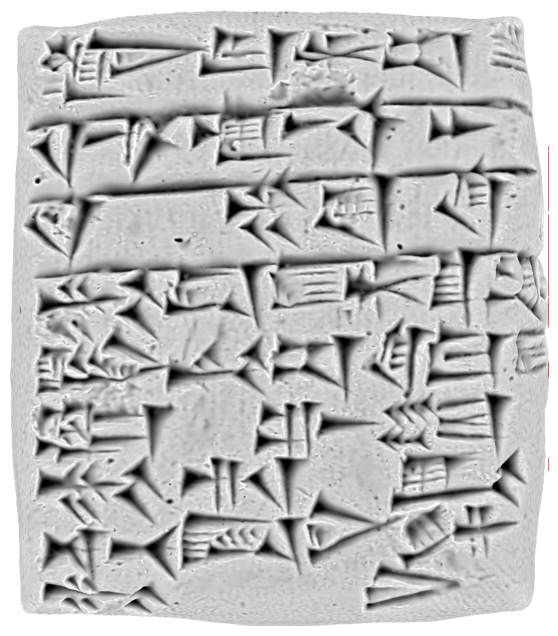

In [5]:
from plot_utils import run_and_plot

# load weights
model.load_state_dict(torch.load("weights/epoch_12.pth"))

run_and_plot("../HeiCuBeDa/Images_MSII_Filter/HS_1295_HeiCuBeDa_GMOCF_r1.50_n4_v512_06_back.png", model, transforms,thres=0.35);
# run_and_plot("animalwalk.jpg", model, transforms,thres=0.5);